In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler

In [11]:
data = pd.read_csv('raw.csv', sep=',',engine='python')
df = data
len(df)

5776

In [12]:
data_new = df.dropna(subset=['ASH','INSUL','TAAV','RH','dayav_ta','dayav_rh','MET','TRAV','VELAV'])
data_new.to_csv('raw_new.csv')
# get features and thermal sensation
print(np.shape(data_new))
y = data_new['ASH']
x = data_new[['INSUL','TRAV','VELAV','TAAV']]
y = np.round(y)
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(y)
x.iloc[0]

(3275, 81)


INSUL     0.83
TRAV     24.17
VELAV     0.11
TAAV     24.60
Name: 2, dtype: float64

# undersampling

In [26]:
rus = RandomUnderSampler(random_state=0)
rus.fit(x, encoded)
x, encoded = rus.fit_sample(x, encoded)
for i in range(7):
    print(np.shape(np.where(encoded==i))[1])

48
48
48
48
48
48
48


# train 

In [9]:
import sklearn.preprocessing, sklearn.decomposition,sklearn.linear_model, sklearn.pipeline, sklearn.metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import datasets, svm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier

In [10]:
# train without undersampling
mapper = DataFrameMapper([(['INSUL'], None),
                         (['TRAV'], None),
                          (['TAAV'], None),
                         (['VELAV'],None)])
mapper.fit_transform(x.copy())
# count the number of thermal sensation
# bool = (y==3)
# len(y[bool])

array([[ 0.83   , 24.17   , 24.6    ,  0.11   ],
       [ 0.68   , 24.2    , 24.6    ,  0.09   ],
       [ 0.92   , 24.38   , 24.6    ,  0.12   ],
       ...,
       [ 1.10172, 23.16   , 23.16   ,  0.1    ],
       [ 0.99238, 22.62   , 22.62   ,  0.08   ],
       [ 0.87924, 23.1    , 22.94   ,  0.05   ]])

In [11]:
clf2 = RandomForestClassifier(n_estimators=50, max_depth = 3, random_state=0)
# RF
print(cross_val_score(clf2,x,encoded,cv=5))

[0.43465046 0.48018293 0.47022901 0.47779479 0.48085758]


# test

In [12]:
# testing
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

In [13]:
# evaluation
clf2.fit(x,encoded)
predicted2 = cross_val_predict(clf2, x, encoded, cv=5)
predicted2 = clf2.predict(x)
matrix_sensation = confusion_matrix(encoded, predicted2)
print(metrics.accuracy_score(encoded, predicted2))
f1=f1_score(encoded, predicted2, average='weighted') 
print(f1)

0.4858015267175573
0.33870076019610706


/Users/lusiliang93/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
# test with random forest
clf2.fit(x,encoded)
#predicted = clf2.predict(x.iloc[0].reshape(1,-1))
predicted = clf2.predict(x[0].reshape(1,-1))
print(x[0])
predicted

[ 0.76312571 19.4        35.6       ]


array([0])

In [16]:
import pickle
filename = 'rf_model_final.sav'
# python2
#pickle.dump(clf,open(filename,'wb'),protocol=2)
# python3
pickle.dump(clf2,open(filename,'wb'))
load_model = pickle.load(open(filename,'rb'))
pred = load_model.predict(x.iloc[0].reshape(1,-1))
pred

/Users/lusiliang93/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


array([3])

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


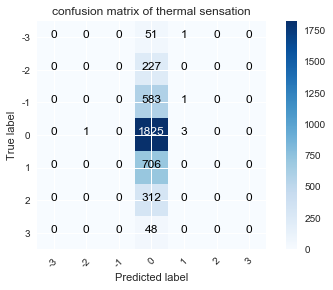

In [18]:
class_names = [-3,-2,-1,0,1,2,3]
plot_confusion_matrix(matrix_sensation,classes=class_names,
                      title='confusion matrix of thermal sensation')

In [19]:
from imblearn.over_sampling import SMOTE

In [20]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(x, encoded)

In [21]:
print(cross_val_score(clf2,X_train_res,y_train_res,cv=5))

[0.28532397 0.29937549 0.31303669 0.30288837 0.28962818]


In [22]:
    temps = np.arange(10,40,0.01)
    states=np.zeros((len(temps),3))
    states[:,0] = 1
    states[:,2] = 60
    states[:,1] = temps

In [23]:
state=states[0]
states.tolist().index(state.tolist())

0

In [28]:
load_model.predict(np.array([0.5,-10,60]).reshape(1,-1))

array([3])